# Import Libraries

In [66]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully
TensorFlow version: 2.20.0


# Load MIMIC Perform AF Dataset

**Dataset info:**
- AF: 19 pasien (mimic_perform_af_001 - mimic_perform_af_019)
- Non-AF: 16 pasien (mimic_perform_non_af_001 - mimic_perform_non_af_016)
- Sampling Rate: 125Hz
- Duration: ~20 menit per pasien (150,000 samples)
- **Columns: Time, PPG, ECG** ← Menggunakan PPG dan ECG

In [67]:
# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(current_dir)

af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

# List files
af_files = sorted(glob.glob(os.path.join(af_folder, '*_data.csv')))
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*_data.csv')))

print("="*60)
print("DATASET: MIMIC Perform AF (All Signals)")
print("="*60)
print(f"\n📁 AF Folder: {af_folder}")
print(f"   Patients: {len(af_files)}")
print(f"\n📁 Non-AF Folder: {nonaf_folder}")
print(f"   Patients: {len(nonaf_files)}")
print(f"\n📊 Total Patients: {len(af_files) + len(nonaf_files)}")
print(f"\n📋 Signals Used: PPG, ECG")

DATASET: MIMIC Perform AF (All Signals)

📁 AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\af
   Patients: 19

📁 Non-AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\non-af
   Patients: 16

📊 Total Patients: 35

📋 Signals Used: PPG, ECG


## Visualize Sample Data

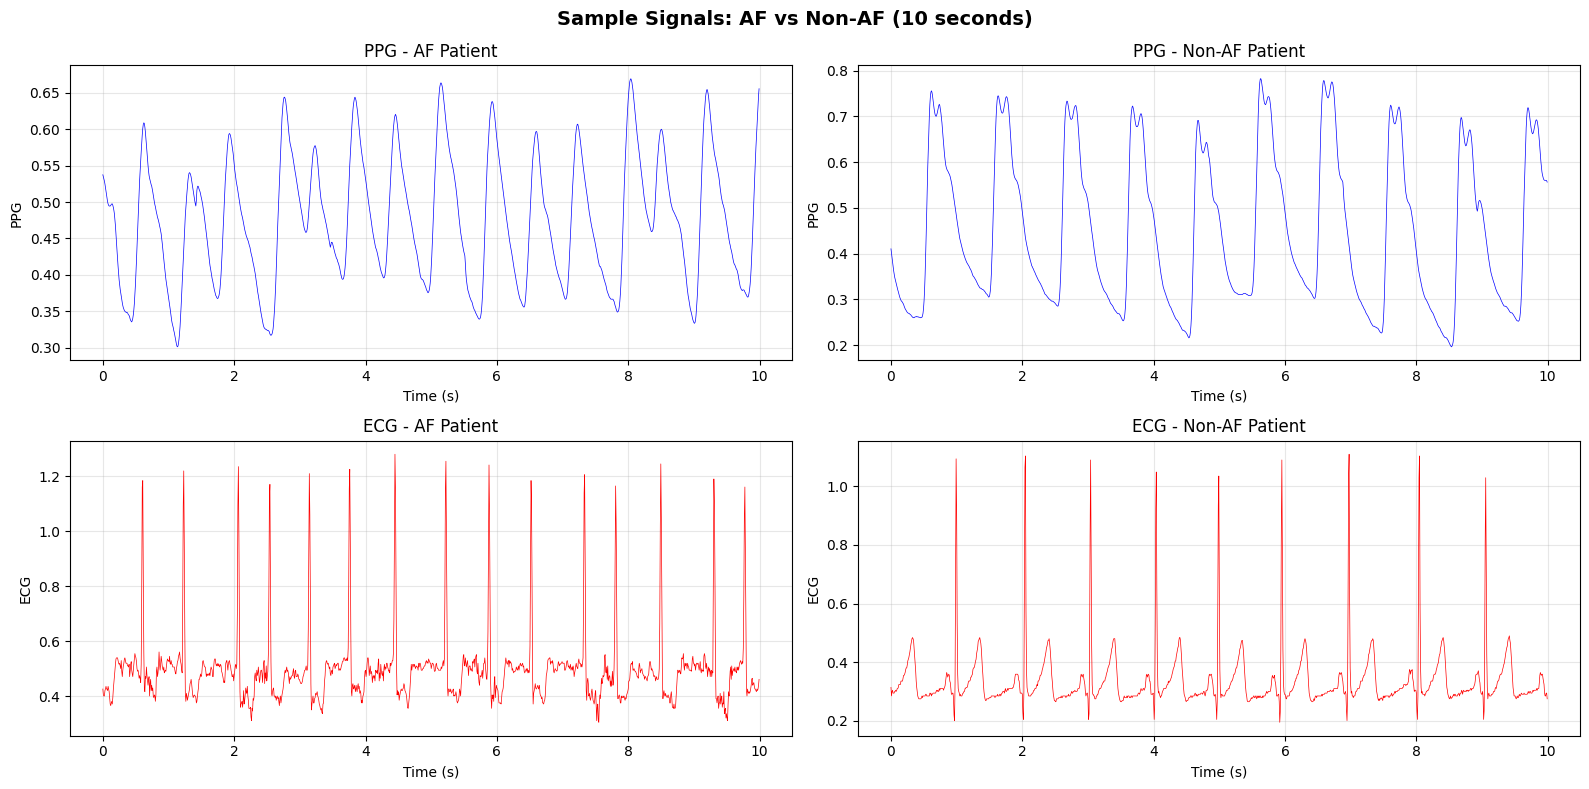

In [68]:
# Load sample data untuk visualisasi
sample_af = pd.read_csv(af_files[0])
sample_nonaf = pd.read_csv(nonaf_files[0])

# Plot 10 detik pertama (1250 samples)
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
n_samples = 1250  # 10 seconds

signals = ['PPG', 'ECG']
colors = ['blue', 'red']

for i, (signal, color) in enumerate(zip(signals, colors)):
    # AF
    axes[i, 0].plot(sample_af['Time'][:n_samples], sample_af[signal][:n_samples], color=color, linewidth=0.5)
    axes[i, 0].set_title(f'{signal} - AF Patient')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel(signal)
    axes[i, 0].grid(True, alpha=0.3)
    
    # Non-AF
    axes[i, 1].plot(sample_nonaf['Time'][:n_samples], sample_nonaf[signal][:n_samples], color=color, linewidth=0.5)
    axes[i, 1].set_title(f'{signal} - Non-AF Patient')
    axes[i, 1].set_xlabel('Time (s)')
    axes[i, 1].set_ylabel(signal)
    axes[i, 1].grid(True, alpha=0.3)

plt.suptitle('Sample Signals: AF vs Non-AF (10 seconds)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Train-Test Split (Sesuai Jurnal: 65% Train, 35% Test)

Split berdasarkan pasien untuk menghindari data leakage

In [69]:
# Split 65% train, 35% test (sesuai jurnal)
# Split per kelas untuk menjaga proporsi

np.random.seed(42)

# Shuffle files
af_files_shuffled = np.random.permutation(af_files).tolist()
nonaf_files_shuffled = np.random.permutation(nonaf_files).tolist()

# Split AF: 65% train, 35% test
n_af_train = int(len(af_files) * 0.65)
train_af = af_files_shuffled[:n_af_train]
test_af = af_files_shuffled[n_af_train:]

# Split Non-AF: 65% train, 35% test
n_nonaf_train = int(len(nonaf_files) * 0.65)
train_nonaf = nonaf_files_shuffled[:n_nonaf_train]
test_nonaf = nonaf_files_shuffled[n_nonaf_train:]

print("="*60)
print("DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)")
print("="*60)
print(f"\n📊 AF Split:")
print(f"   Train: {len(train_af)} patients")
print(f"   Test: {len(test_af)} patients")
print(f"\n📊 Non-AF Split:")
print(f"   Train: {len(train_nonaf)} patients")
print(f"   Test: {len(test_nonaf)} patients")
print(f"\n📊 Total:")
print(f"   Train: {len(train_af) + len(train_nonaf)} patients")
print(f"   Test: {len(test_af) + len(test_nonaf)} patients")

DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)

📊 AF Split:
   Train: 12 patients
   Test: 7 patients

📊 Non-AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Total:
   Train: 22 patients
   Test: 13 patients


## Load Data Function (PPG + ECG)

In [70]:
def load_patient_data(file_path, max_samples=150000):
    """
    Load PPG dan ECG data dari file CSV.
    Returns: ppg, ecg arrays
    """
    df = pd.read_csv(file_path)
    
    # Limit samples
    if len(df) > max_samples:
        df = df.iloc[:max_samples]
    
    # Get PPG and ECG
    ppg = df['PPG'].values
    ecg = df['ECG'].values
    
    # Handle NaN with interpolation
    if np.any(np.isnan(ppg)):
        ppg = pd.Series(ppg).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').values
    if np.any(np.isnan(ecg)):
        ecg = pd.Series(ecg).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').values
    
    return ppg, ecg

print("✅ Load function defined (PPG, ECG)")

✅ Load function defined (PPG, ECG)


## Feature Extraction (Sesuai Jurnal)

5 fitur statistik per window **untuk setiap sinyal**:
1. Skewness
2. Kurtosis
3. Minimum
4. Maximum
5. Standard Deviation

**Total: 5 fitur × 2 sinyal = 10 fitur per window**

In [71]:
# Parameters
SAMPLING_RATE = 125  # Hz
WINDOW_SIZE = SAMPLING_RATE  # 1 second = 125 samples
SEQUENCE_LENGTH = 10  # 10 windows = 10 seconds context
N_FEATURES = 10  # 5 features × 2 signals (PPG + ECG)

def extract_statistical_features(window):
    """
    Extract 5 statistical features (sesuai jurnal):
    Skewness, Kurtosis, Min, Max, STD
    """
    return np.array([
        skew(window),
        kurtosis(window),
        np.min(window),
        np.max(window),
        np.std(window)
    ])

def extract_features_from_signals(ppg, ecg, window_size=125):
    """
    Extract features dari PPG dan ECG signals.
    Returns: array of shape (n_windows, 10)
    """
    n_windows = min(len(ppg), len(ecg)) // window_size
    features = []
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        
        # Extract features from each signal
        ppg_features = extract_statistical_features(ppg[start:end])
        ecg_features = extract_statistical_features(ecg[start:end])
        
        # Concatenate all features
        combined = np.concatenate([ppg_features, ecg_features])
        features.append(combined)
    
    return np.array(features)

print(f"📊 Parameters:")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")
print(f"   Window Size: {WINDOW_SIZE} samples (1 second)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} windows")
print(f"\n📊 Features per window:")
print(f"   PPG: 5 features (Skewness, Kurtosis, Min, Max, STD)")
print(f"   ECG: 5 features (Skewness, Kurtosis, Min, Max, STD)")
print(f"   Total: {N_FEATURES} features per window")

📊 Parameters:
   Sampling Rate: 125 Hz
   Window Size: 125 samples (1 second)
   Sequence Length: 10 windows

📊 Features per window:
   PPG: 5 features (Skewness, Kurtosis, Min, Max, STD)
   ECG: 5 features (Skewness, Kurtosis, Min, Max, STD)
   Total: 10 features per window


## Load and Extract Features

In [72]:
def load_and_extract(files, label, desc=""):
    """
    Load files dan extract features dari PPG dan ECG.
    """
    all_features = []
    all_labels = []
    
    for f in files:
        patient_id = os.path.basename(f).replace('_data.csv', '')
        print(f"   Loading {patient_id}...", end=" ")
        
        # Load PPG and ECG
        ppg, ecg = load_patient_data(f)
        
        # Extract features
        features = extract_features_from_signals(ppg, ecg, WINDOW_SIZE)
        labels = np.full(len(features), label)
        
        all_features.append(features)
        all_labels.append(labels)
        
        print(f"✓ {len(features)} windows")
    
    return np.vstack(all_features), np.concatenate(all_labels)

# Load Training Data
print("="*60)
print("LOADING TRAINING DATA (PPG + ECG)")
print("="*60)

print("\n📥 Loading AF patients (Train)...")
X_train_af, y_train_af = load_and_extract(train_af, label=1)

print("\n📥 Loading Non-AF patients (Train)...")
X_train_nonaf, y_train_nonaf = load_and_extract(train_nonaf, label=0)

# Combine training data
X_train = np.vstack([X_train_af, X_train_nonaf])
y_train = np.concatenate([y_train_af, y_train_nonaf])

print("\n" + "="*60)
print("LOADING TEST DATA (PPG + ECG)")
print("="*60)

print("\n📥 Loading AF patients (Test)...")
X_test_af, y_test_af = load_and_extract(test_af, label=1)

print("\n📥 Loading Non-AF patients (Test)...")
X_test_nonaf, y_test_nonaf = load_and_extract(test_nonaf, label=0)

# Combine test data
X_test = np.vstack([X_test_af, X_test_nonaf])
y_test = np.concatenate([y_test_af, y_test_nonaf])

print("\n" + "="*60)
print("✅ DATA LOADED (PPG + ECG)")
print("="*60)
print(f"\n📊 Training Data:")
print(f"   Samples: {len(X_train)}")
print(f"   Features: {X_train.shape[1]} (5 per signal × 2 signals)")
print(f"   AF: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"\n📊 Test Data:")
print(f"   Samples: {len(X_test)}")
print(f"   Features: {X_test.shape[1]}")
print(f"   AF: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.1f}%)")

LOADING TRAINING DATA (PPG + ECG)

📥 Loading AF patients (Train)...
   Loading mimic_perform_af_001... ✓ 1200 windows
   Loading mimic_perform_af_006... ✓ 1200 windows
   Loading mimic_perform_af_006... ✓ 1200 windows
   Loading mimic_perform_af_012... ✓ 1200 windows
   Loading mimic_perform_af_012... ✓ 1200 windows
   Loading mimic_perform_af_002... ✓ 1200 windows
   Loading mimic_perform_af_002... ✓ 1200 windows
   Loading mimic_perform_af_009... ✓ 1200 windows
   Loading mimic_perform_af_009... ✓ 1200 windows
   Loading mimic_perform_af_017... ✓ 1200 windows
   Loading mimic_perform_af_017... ✓ 1200 windows
   Loading mimic_perform_af_004... ✓ 1200 windows
   Loading mimic_perform_af_004... ✓ 1200 windows
   Loading mimic_perform_af_014... ✓ 1200 windows
   Loading mimic_perform_af_014... ✓ 1200 windows
   Loading mimic_perform_af_016... ✓ 1200 windows
   Loading mimic_perform_af_016... ✓ 1200 windows
   Loading mimic_perform_af_018... ✓ 1200 windows
   Loading mimic_perform_af_018.

## Feature Names

In [73]:
# Feature names untuk interpretasi
feature_names = []
for signal in ['PPG', 'ECG']:
    for stat in ['Skewness', 'Kurtosis', 'Min', 'Max', 'STD']:
        feature_names.append(f"{signal}_{stat}")

print("📋 Feature Names:")
for i, name in enumerate(feature_names):
    print(f"   {i+1:2d}. {name}")

📋 Feature Names:
    1. PPG_Skewness
    2. PPG_Kurtosis
    3. PPG_Min
    4. PPG_Max
    5. PPG_STD
    6. ECG_Skewness
    7. ECG_Kurtosis
    8. ECG_Min
    9. ECG_Max
   10. ECG_STD


## Preprocessing

In [74]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalized")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

✅ Features normalized
   Train shape: (26400, 10)
   Test shape: (15600, 10)


In [75]:
def create_sequences(data, labels, sequence_length=10):
    """
    Create sequences for LSTM.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
print(f"Creating sequences with {SEQUENCE_LENGTH} timesteps...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created:")
print(f"   X_train: {X_train_seq.shape} (samples, timesteps, features)")
print(f"   X_test: {X_test_seq.shape}")

Creating sequences with 10 timesteps...

✅ Sequences created:
   X_train: (26391, 10, 10) (samples, timesteps, features)
   X_test: (15591, 10, 10)


# Attention-based LSTM Model (Sesuai Jurnal)

**Arsitektur:**
- 5 LSTM layers
- nhidden = 30
- Attention block dengan Softmax
- Learning rate = 0.001
- **Input: 10 features (PPG + ECG)**

In [76]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        attention_weights = K.softmax(e, axis=-1)
        output = x * attention_weights
        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

print("✅ AttentionLayer defined")

✅ AttentionLayer defined


In [77]:
def build_attention_lstm_model(n_timesteps, n_features=10, n_hidden=30, n_lstm_layers=5):
    """
    Build Attention-based LSTM model (sesuai jurnal).
    Modified for 10 features (PPG + ECG).
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = inputs
    
    # LSTM layers dengan Attention
    for i in range(n_lstm_layers - 1):
        x = LSTM(n_hidden, return_sequences=True, name=f'lstm_{i+1}')(x)
        x = Dropout(0.2)(x)
        x = AttentionLayer(name=f'attention_{i+1}')(x)
    
    # Final LSTM
    x = LSTM(n_hidden, return_sequences=False, name=f'lstm_{n_lstm_layers}')(x)
    x = Dropout(0.2)(x)
    
    # Dense untuk feature extraction (untuk XGBoost)
    x = Dense(32, activation='relu', name='dense_features')(x)
    x = Dropout(0.3)(x)
    
    # Output
    outputs = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall']
    )
    
    return model

# Build model
print("Building Attention-based LSTM Model...")
print("Specifications (sesuai jurnal):")
print("  - LSTM Layers: 5")
print("  - Hidden Units: 30")
print("  - Attention: Softmax-based")
print(f"  - Timesteps: {SEQUENCE_LENGTH}")
print(f"  - Features: {N_FEATURES} (PPG + ECG)")
print("  - Learning Rate: 0.001")

model = build_attention_lstm_model(
    n_timesteps=SEQUENCE_LENGTH, 
    n_features=N_FEATURES, 
    n_hidden=30, 
    n_lstm_layers=5
)
model.summary()

Building Attention-based LSTM Model...
Specifications (sesuai jurnal):
  - LSTM Layers: 5
  - Hidden Units: 30
  - Attention: Softmax-based
  - Timesteps: 10
  - Features: 10 (PPG + ECG)
  - Learning Rate: 0.001


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 30)         │         4,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,945 (152.13 KB)

 Trainable params: 38,945 (152.13 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Train LSTM (tanpa validation - sesuai jurnal)
print("Training Attention-based LSTM Model...")

# Class weights untuk handle imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"Class weights: {class_weight_dict}")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final accuracy: {history.history['accuracy'][-1]:.4f}")

Training Attention-based LSTM Model...
Class weights: {0: np.float64(1.099625), 1: np.float64(0.9169272461955389)}
Epoch 1/50
Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4968 - loss: 0.6932 - recall: 0.4831
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4968 - loss: 0.6932 - recall: 0.4831
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5032 - loss: 0.6932 - recall: 0.5812
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5032 - loss: 0.6932 - recall: 0.5812
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5271 - loss: 0.6932 - recall: 0.8113
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5271 - loss: 0.6932 - recall: 0.8113
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4885 - loss: 0.6932 - recall: 0.4343
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4885 - loss: 0.6932 - recall: 0.4343
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 

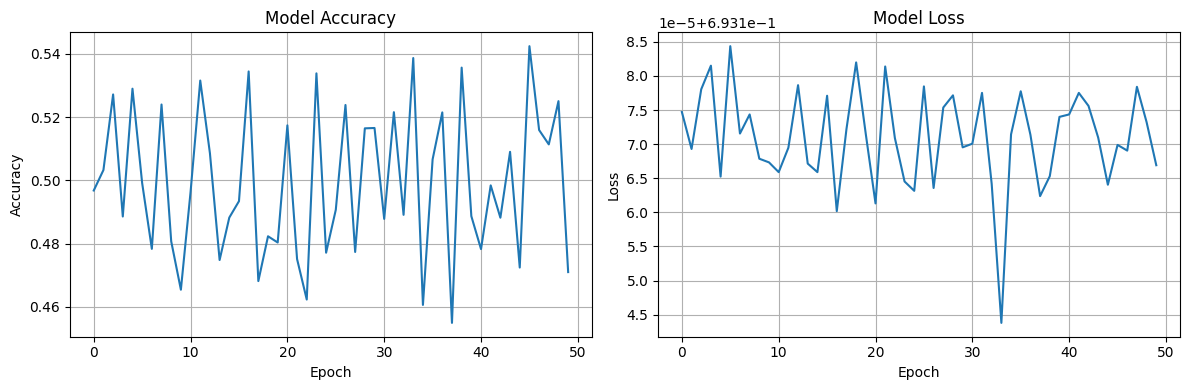

In [79]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# Extract Features untuk XGBoost

In [80]:
# Build Feature Extractor
lstm_weight_extractor = Model(
    inputs=model.inputs, 
    outputs=model.get_layer('dense_features').output
)

# Extract weights
X_train_weights = lstm_weight_extractor.predict(X_train_seq)
X_test_weights = lstm_weight_extractor.predict(X_test_seq)

print("✅ Features extracted from LSTM")
print(f"   Train: {X_train_weights.shape}")
print(f"   Test: {X_test_weights.shape}")

825/825 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
825/825 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
✅ Features extracted from LSTM
   Train: (26391, 32)
   Test: (15591, 32)
✅ Features extracted from LSTM
   Train: (26391, 32)
   Test: (15591, 32)


# XGBoost Classifier (Sesuai Jurnal)

**Parameters:**
- eta = 0.2
- nrounds = 170
- max_depth = 12

In [81]:
# XGBoost dengan parameter dari jurnal
xgb_model = XGBClassifier(
    learning_rate=0.2,
    n_estimators=170,
    max_depth=12,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train_weights, y_train_seq)
print("✅ XGBoost trained")

Training XGBoost...
✅ XGBoost trained
✅ XGBoost trained


# Model Evaluation

In [82]:
# Evaluate Hybrid model
y_prob = xgb_model.predict_proba(X_test_weights)[:, 1]
y_pred = xgb_model.predict(X_test_weights)

# Metrics
acc = accuracy_score(y_test_seq, y_pred)
prec = precision_score(y_test_seq, y_pred, zero_division=0)
recall = recall_score(y_test_seq, y_pred, zero_division=0)
f1 = f1_score(y_test_seq, y_pred, zero_division=0)
roauc = roc_auc_score(y_test_seq, y_prob) if len(np.unique(y_pred)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (LSTM + XGBoost)")
print("Dataset: MIMIC Perform AF (PPG + ECG)")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"   Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1 Score : {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC AUC  : {roauc:.4f} ({roauc*100:.2f}%)")

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred, target_names=['Non-AF', 'AF'], zero_division=0))

HYBRID MODEL EVALUATION (LSTM + XGBoost)
Dataset: MIMIC Perform AF (PPG + ECG)

📊 Performance Metrics:
   Accuracy : 0.5382 (53.82%)
   Precision: 0.5382 (53.82%)
   Recall   : 1.0000 (100.00%)
   F1 Score : 0.6998 (69.98%)
   ROC AUC  : 0.5000 (50.00%)

Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.00      0.00      0.00      7200
          AF       0.54      1.00      0.70      8391

    accuracy                           0.54     15591
   macro avg       0.27      0.50      0.35     15591
weighted avg       0.29      0.54      0.38     15591



In [83]:
# Comparison
print("="*60)
print("PERBANDINGAN METODE")
print("="*60)

# LSTM only
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype(int).flatten()
acc_lstm = accuracy_score(y_test_seq, y_pred_lstm)
print(f"\n1. LSTM Only: {acc_lstm*100:.2f}%")

# XGBoost direct (on statistical features)
xgb_direct = XGBClassifier(
    learning_rate=0.2, n_estimators=170, max_depth=12,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_direct.fit(X_train_scaled, y_train)
y_pred_direct = xgb_direct.predict(X_test_scaled)
acc_direct = accuracy_score(y_test, y_pred_direct)
print(f"2. XGBoost Direct (10 features): {acc_direct*100:.2f}%")

# Hybrid
print(f"3. Hybrid LSTM+XGBoost: {acc*100:.2f}%")

print("\n" + "="*60)
best = max([(acc_lstm, 'LSTM'), (acc_direct, 'XGBoost Direct'), (acc, 'Hybrid')])
print(f"✅ Metode terbaik: {best[1]} ({best[0]*100:.2f}%)")

PERBANDINGAN METODE
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1. LSTM Only: 53.82%

1. LSTM Only: 53.82%
2. XGBoost Direct (10 features): 51.62%
3. Hybrid LSTM+XGBoost: 53.82%

✅ Metode terbaik: LSTM (53.82%)
2. XGBoost Direct (10 features): 51.62%
3. Hybrid LSTM+XGBoost: 53.82%

✅ Metode terbaik: LSTM (53.82%)


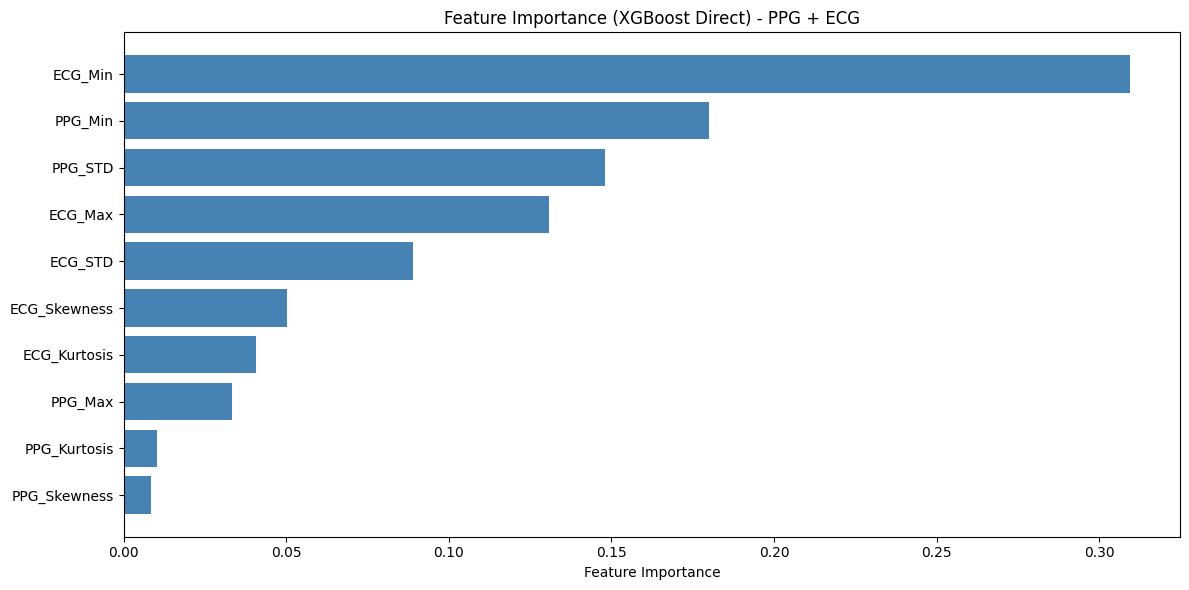


📊 Top 5 Most Important Features:
   1. ECG_Min: 0.3094
   2. PPG_Min: 0.1801
   3. PPG_STD: 0.1481
   4. ECG_Max: 0.1307
   5. ECG_STD: 0.0890


In [84]:
# Feature Importance dari XGBoost Direct
plt.figure(figsize=(12, 6))
importance = xgb_direct.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

plt.barh(range(len(importance)), importance[sorted_idx], color='steelblue')
plt.yticks(range(len(importance)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (XGBoost Direct) - PPG + ECG')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top 5 features
print("\n📊 Top 5 Most Important Features:")
for i in range(5):
    print(f"   {i+1}. {feature_names[sorted_idx[i]]}: {importance[sorted_idx[i]]:.4f}")

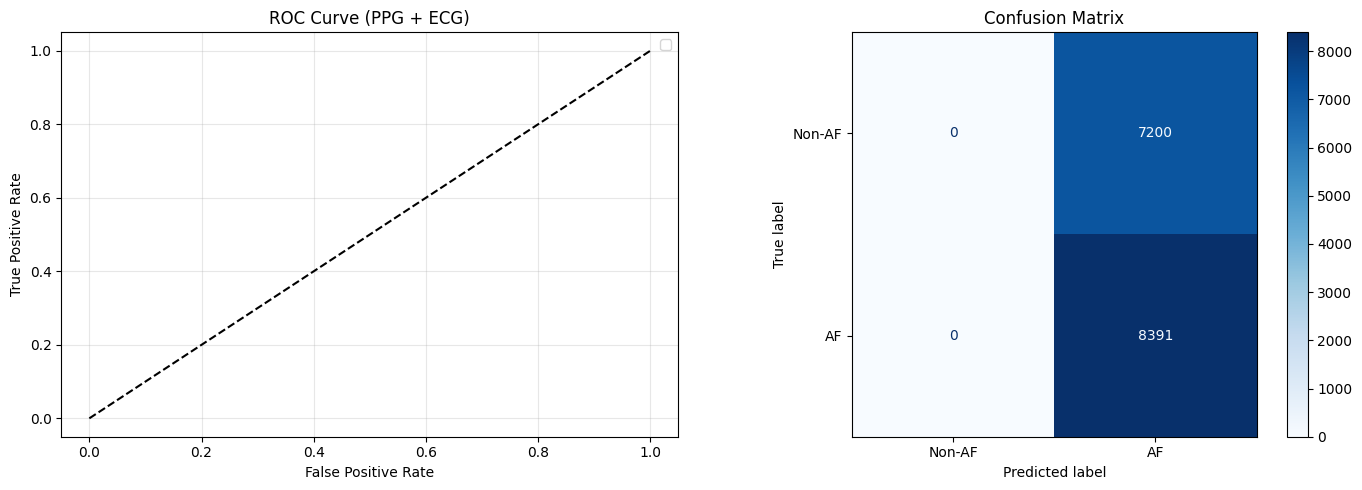

In [85]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
if len(np.unique(y_pred)) > 1:
    fpr, tpr, _ = roc_curve(y_test_seq, y_prob)
    axes[0].plot(fpr, tpr, label=f"AUC = {roauc:.4f}", color='darkorange', linewidth=2)
    axes[0].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (PPG + ECG)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp.plot(cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Save Models

In [86]:
# Save models
os.makedirs('models/MIMIC_All_Signals', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

model.save(f'models/MIMIC_All_Signals/lstm_{timestamp}.h5')
xgb_model.save_model(f'models/MIMIC_All_Signals/xgboost_{timestamp}.json')
joblib.dump(scaler, f'models/MIMIC_All_Signals/scaler_{timestamp}.pkl')

print("✅ Models saved!")

✅ Models saved!


# Summary

In [87]:
print("="*70)
print("SUMMARY")
print("="*70)

print("\n📋 DATASET: MIMIC Perform AF")
print(f"   AF Patients: {len(af_files)}")
print(f"   Non-AF Patients: {len(nonaf_files)}")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")

print("\n📋 SIGNALS USED:")
print("   ✓ PPG (Photoplethysmogram)")
print("   ✓ ECG (Electrocardiogram)")

print("\n📋 DATA SPLIT (sesuai jurnal):")
print(f"   Train: {len(train_af)+len(train_nonaf)} patients (65%)")
print(f"   Test: {len(test_af)+len(test_nonaf)} patients (35%)")

print("\n📋 FEATURES:")
print(f"   Per signal: 5 (Skewness, Kurtosis, Min, Max, STD)")
print(f"   Total: {N_FEATURES} features (5 × 3 signals)")
print(f"   Total: {N_FEATURES} features (5 × 2 signals)")
print("\n📋 METHODOLOGY (sesuai jurnal):")
print("   1. Feature Extraction: 5 statistical features × 3 signals")
print("   1. Feature Extraction: 5 statistical features × 2 signals")
print("   3. XGBoost: eta=0.2, nrounds=170, max_depth=12")

print("\n📊 RESULTS:")
print(f"   Accuracy : {acc*100:.2f}%")
print(f"   Precision: {prec*100:.2f}%")
print(f"   Recall   : {recall*100:.2f}%")
print(f"   F1 Score : {f1*100:.2f}%")
print(f"   ROC AUC  : {roauc*100:.2f}%")

print("\n" + "="*70)

SUMMARY

📋 DATASET: MIMIC Perform AF
   AF Patients: 19
   Non-AF Patients: 16
   Sampling Rate: 125 Hz

📋 SIGNALS USED:
   ✓ PPG (Photoplethysmogram)
   ✓ ECG (Electrocardiogram)

📋 DATA SPLIT (sesuai jurnal):
   Train: 22 patients (65%)
   Test: 13 patients (35%)

📋 FEATURES:
   Per signal: 5 (Skewness, Kurtosis, Min, Max, STD)
   Total: 10 features (5 × 3 signals)
   Total: 10 features (5 × 2 signals)

📋 METHODOLOGY (sesuai jurnal):
   1. Feature Extraction: 5 statistical features × 3 signals
   1. Feature Extraction: 5 statistical features × 2 signals
   3. XGBoost: eta=0.2, nrounds=170, max_depth=12

📊 RESULTS:
   Accuracy : 53.82%
   Precision: 53.82%
   Recall   : 100.00%
   F1 Score : 69.98%
   ROC AUC  : 50.00%

